***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)
    * Previous: [5.2 Sampling functions and PSFs](5_2_sampling_functions_and_psfs.ipynb) 
    * Next: [5.4 The Dirty Image and Visibility Weights](5_4_imaging_weights.ipynb)

***

Import standard modules:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
from IPython.display import Image, display, clear_output
from ipywidgets import HBox, Label, FloatSlider, Layout
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [11]:
from IPython.display import Image
import track_simulator
import AA_filter

## 5.3 FFT过程中的网格化（Gridding）和去网格化（Degridding）  Gridding and Degridding for using the FFT <a id='imaging:sec:gridding'></a>

我们在上一节介绍了几种采样函数。这些采样函数本身是离散的，可以显示为图像，每张图像都由像素网格点构成，且每个像素的大小相同。这类采样被称为规则采样，在傅立叶变换过程中可以使用快速傅立叶变换（Fast Fourier Transform，FFT）。之所以被称之为“快速”傅立叶变换，是因为FFT计算起来比直接傅立叶变换（Direct Fourier Transform，DFT）更高效。下面是两种变换方法的计算复杂度估算。假设有一张包括$N^2$个像素的图，则FFT的计算次数约为$2N^2\log(N)$。而DFT的运算复杂度还跟可见度的数量$M$有关，每个像素需要进行$M$次复指数运算和乘法运算，因此一共需要$N^2M$次计算，此处$M\approx N^2$。具体来说，DFT根据下面的公式计算出每个像素的亮度：

In the previous section several sampling functions were presented. There the sampling functions were already neatly discretized and displayed as images. Each image was a grid of pixels (all with the same size). Fourier inverting such regularly sampled data is done with a fast Fourier Transform (FFT) algorithm. This is called the "fast" Fourier Transform because it is computationally more efficient that the Direct Fourier Transform (DFT). To give an idea of how fast this algorithm is, if there are $N^2$ pixels in the image, the FFT takes roughly $2N^2\log(N)$ computational operations. In contrast, the complexity of the DFT also depends on the number of visibilities $M$ and takes $N^2M$ steps. Here $M\approx N^2$ and for each pixel we must take $M$ complex exponentiations and multiplications. Specifically, the DFT calculates the intensity of each pixel:

\begin{equation}
 I(l,m) = \sum_{k=0}^{M-1}V_k(u,v)e^{2\pi i (lu+mv)}\text{, }V_k\text{ are the M measurements taken by the telescope}
\end{equation}

由此可见，随着基线数量和观测时间的增加，FFT方法消耗的时间将远小于DFT。但是射电干涉仪并不是规则采样，因此不能直接对观测得到的可见度数据使用FFT。如果要用FFT，必须对原始观测数据进行重新采样，把观测数据置于规则间隔的网格点上，这个重新采样过程（gridding）和逆过程（degridding）是本节内容的核心。我们使用FFT进行成图的原因在于它的计算速度比DFT快，而网格化gridding和去网格化degridding过程也是因为使用了FFT。

From this it should be clear that as the number of baselines or observation time is increased, the FFT approach would be far less time-consuming than the the direct approach. Unfortunately radio interferometers don't take measurements at regular intervals, and thus an FFT cannot be used on the observation data directly. Instead the data has to be *resampled* onto a grid with points spaced at regular intervals before taking the FFT. This resampling process (called *gridding*) and its inverse (called *degridding*) is the topic of this section. The big idea here is that we do gridding and degridding because it enables us to create an image faster than if we did the DFT.

后面会看到，一些uv空间图像去卷积算法（如Cotton-Schwab ➞ 主-次循环算法）需要把图像空间的源转换到不规则的测量空间，因此需要一个精确的去网格化操作，通过插值，把规则采样可见度变回到上述的uv轨迹。

As you will see later some u,v space image deconvolution algorithms such as the Cotton-Schwab ➞ major-minor cycle algorithm require that sources in image space are reconverted back into the non-regular measurement space. Here an accurate degridding operation is required to "interpolate" regularly sampled visibilities back onto the u,v tracks shown above.

FFT方法不仅有重采样问题，还存在“混叠”问题。FFT假定输入信号（这里为空间频率域）具有周期性，通过重采样和逆FFT所获得的图像会表现出规则间隔的重复：例如靠近图像顶部的源会在图像的底部重复出现。因此需要引入滤波器，只对视场范围内的信号进行重建。产生混叠的原因在于是在网格上对可见度进行奈奎斯特采样([$\S$ 2.9 &#10142;](../2_Mathematical_Groundwork/2_9_sampling_theory.ipynb))。

In addition to the issue of resampling when using the FFT transform approach, is the issue of *aliasing*. The FFT assumes that the input signal (here the spatial frequency domain) is periodic in nature. The resultant image constructed by resampling and inverse FFT therefore repeats at regular intervals: sources near the top of the image are aliased back into the image at the bottom for instance. This introduces the necessity to filter the image with a filter that only passes signal that falls within the field of view being reconstructed. Aliasing is an effect of Nyquist sampling ([$\S$ 2.9 &#10142;](../2_Mathematical_Groundwork/2_9_sampling_theory.ipynb)) the visibilities based on the grid size. An example of this form of aliasing will be given later on.

本章将讨论以下几点内容：
1、图像分辨率和像素大小
2、网格化和去网格化，以及抗锯齿滤波器
3、天空模型去网格化采样原则、网格化、以及把可见度转化成脏图

The following points will be discussed in this chapter:
1. Image resolution and pixel size
2. Gridding and degridding, along with a discussion on the use anti-aliasing filters
3. Sample code for degridding a model sky, and gridding and inverting visibilities to form a dirty image.

### 5.3.1 图像分辨率和像素大小 Image Resolution and Pixel Size

当通过傅立叶变换（直接/快速）从可见度生成图像的时候，需要给出两个参数：一是像素的分辨率，二是图像的大小或者视场的大小（这取决于成图工具）。对于一个$N_l \times N_m$的二维图像来说，如果视场满足小角度近似，且每个像素的分辨率为$(\Delta \theta_l, \Delta \theta_m)$。回想一下，图像大小为$l' = \cos{\theta_l}$, $m' = \cos{\theta_m}$，其分辨率为$\Delta l = \cos{\Delta \theta_l}$, $\Delta m = \cos{\Delta \theta_m}$，小角度近似$\Delta l \sim \Delta \theta_l$, $\Delta m \sim \Delta \theta_m$。尽管很多成像工具在成图的时候不关心小角度近似问题，但是问题始终存在。很多技术通过非线性变换，把球坐标上的一个点映射到一个二维平面，SIN-projection是射电干涉测量中用到的一个标准技术，参考[<cite data-cite='Greisen1994'>AIPS Memo 27</cite> &#10548;](ftp://ftp.aoc.nrao.edu/pub/software/aips/TEXT/PUBL/AIPSMEMO27.PS)中对各种坐标投影的详细讨论。

When generating an image from visibilities, using either a direct or fast Fourier transform, two parameters need to be defined: the resolution of each pixel and the extent of the image either as the number of pixels or as the size of the field of view (depending on the particular imager). An image will be a two-dimensional array of size $N_l \times N_m$ and each pixel will have a resolution of $(\Delta \theta_l, \Delta \theta_m)$ if we are making the small angle approximation for the field of view. Recall that the image size is $l' = \cos{\theta_l}$, $m' = \cos{\theta_m}$, the resolution is $\Delta l = \cos{\Delta \theta_l}$, $\Delta m = \cos{\Delta \theta_m}$ and in the small angle approximation $\Delta l \sim \Delta \theta_l$, $\Delta m \sim \Delta \theta_m$. Though, many imagers can create images which break the small angle approximation the notation is retained. There are a number of techniques for representing a point in spherical coordinates, via a non-linear transform, on a two-dimensional plane. In radio interferometry the standard technique is SIN-projection, see [<cite data-cite='Greisen1994'>AIPS Memo 27</cite> &#10548;](ftp://ftp.aoc.nrao.edu/pub/software/aips/TEXT/PUBL/AIPSMEMO27.PS) for a detailed discussion of different coordinate projections.

假定分辨率为$(\Delta \theta_l, \Delta \theta_m)$，视场大小为$(\theta_l, \theta_m)$，则相应图像的像素数量（图像大小）为：

Given the the resolution $(\Delta \theta_l, \Delta \theta_m)$ and the desired field of view $(\theta_l, \theta_m)$, the number of pixels in the image (the image size) is

$$N_l = \frac{\theta_l}{\Delta \theta_l}$$

$$N_m = \frac{\theta_m}{\Delta \theta_m}$$

我们知道，空间频率的uv采样和图像的分辨率（像元尺寸）之间必须满足奈奎斯特采样定律。因此，已知干涉仪的分辨率和图像大小，则图像域的分辨率或者像元大小为：

Recall that the uv tracks samples spatial frequency, so therefore the chosen image resolution (cell size) must satisfy the Nyquist relation. For a given interferometer resolution and image size the image domain resolution/grid size $(\Delta \theta_l, \Delta \theta_m)$ is

$$\Delta \theta_l = \frac{1}{2N_l \Delta u} = \frac{1}{2\max{(||\min{u}||,\max{u})}} \text{  radians}$$

$$\Delta \theta_m = \frac{1}{2N_m \Delta v} = \frac{1}{2\max{(||\min{v}||,\max{v})}} \text{  radians}$$

两个域的像素的数量不变，即$N_u = N_l$, $N_v = N_m$。

And the number of pixels is unchanged $N_u = N_l$, $N_v = N_m$.

值得注意的是，像素的数量最好是2的次方，即$N_l = 2^j$, $N_m = 2^k, $ ，$j,k$为正数。这跟FFT的执行方式有关，当输入长度为2的幂时，FFT的效率最高，输入长度为素数时效率最低。例如，生成一幅256x256像素（$2^8$x$2^8$）的图时，所消耗的时间要少于生成251x251的图，尽管前者的总像素点多于后者。另外，按照惯例，干涉测量获得的图像几乎总是正方形。

An important note about the number of pixels is that one should try to use values which are powers of 2, i.e. $N_l = 2^j$, $N_m = 2^k, $ for some positive $j,k$. This is because of how FFT's are implemented, the optimal run-time efficiency of an FFT is with input lengths which are powers of 2 and are least efficient when the input length is a prime number. For example, the time required to generate a 256 by 256 pixel ($2^8$ by $2^8$) image will be less than a 251 by 251 pixel image even though the resulting image will have more pixels. Also, note, interferometric images are almost always square by convention.

当利用FFT进行uv域和图像域之间的转换时，必须按照FFT的相似性把图像缩放到合适大小：

When using the Fast Fourier Transform for the inversion between uv and image space the image has to be scaled to the correct size using the Similarity property of the FFT:
$$V(au, av) \rightleftharpoons \frac{1}{|a|}I(\frac{l}{a},\frac{m}{a})$$

这意味着我们可以根据图像大小（弧度）调整uv轨迹，然后把图像调整到$-0.5N_x\Delta\theta_l \leq l \leq 0.5N_x\Delta\theta_l$ 和$-0.5N_y\Delta\theta_m \leq m \leq 0.5N_y\Delta\theta_m$。这与DFT方法有所不同，DFT可以直接指定每个像素的分辨率。

This implies that we can scale the image to $-0.5N_x\Delta\theta_l \leq l \leq 0.5N_x\Delta\theta_l$ and $-0.5N_y\Delta\theta_m \leq m \leq 0.5N_y\Delta\theta_m$ by scaling with the uv tracks with the image size (in radians). This is in contrast to the approach taken when using the DFT: in the direct per pixel evaluation of the fourier sum the resolution can be specified directly.

### 5.3.2 网格和去网格 Gridding and Degridding

正如您想到的那样，有很多方法可以从规则间隔的坐标系插入或者获取数据。射电成像处理程序中使用最为广泛的插值技术，例如`lwimager`，被称为“卷积重采样’。在这种技术里，每个可见度被赋予一定的权重，然后被“抹到”（smear out，赋值）周围一定距离范围的网格点上。

As you may suspect there are many ways to interpolate data to and from regularly-spaced coordinates. The most widely-used interpolation technique used in radio imaging programs, such as `lwimager`, is known as "convolutional-resampling". In this technique each visibility is weighted and "smeared out" onto grid points that lie within a small distance from the original coordinate.

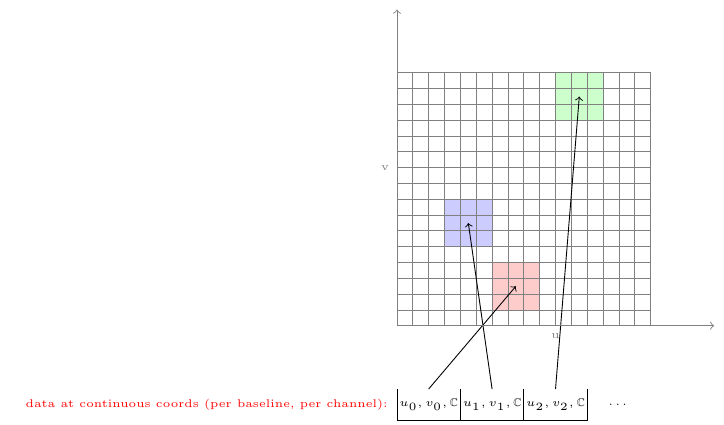

In [12]:
Image(filename="figures/gridding_illustration.png")

图：在连续的uv空间里，以测到的每个可见度为中心，按照权重函数$C(u,v)$扩充出一块有限的“全支持”区域（如图所示）。在网格化时，把测量值按照权重赋值到区域里的各规则网格点，去网格化则相反。对所有可见度做完网格化以后，执行逆快速傅立叶变换得到一张天空的图像（脏图），如果要从天空模型模拟生成一组可见度数据，则执行相反的操作。

*Figure: Each observed visibility is centered at some sampling coordinate
in continuous u,v space and is weighted with some function $C(u,v)$, which extends only to finite “full support” region as illustrated. The result is either binned in a regularly spaced grid when gridding or gathered from this grid when degridding. After all of the observed visibilities have been gridded an Inverse Fast Fourier Transform is performed to create an image of the sky. The reverse operations are done when simulating a set of visibility measurements from a model sky.*

因此，每个网格点的值实际上是它附近所有可见度的加权和，一维描述为：

The value at each grid point, then, is a weighted accumulation of all the nearby visibilties. In one dimension this can be stated as (visually illustrated below):

\begin{equation}
 (\forall a \in \{1,2,\dots,N\}) \mathscr{V}(a\Delta{x}) = \sum_{\substack{
                                                                     i | x_i \geq a\Delta{x}-\text{half support}, \\ 
                                                                     x_i \leq a\Delta{x}+\text{half support}}
                                                                 }{\mathscr{V}(x_i) \, C(a\Delta{x}-x_i)}
\end{equation}

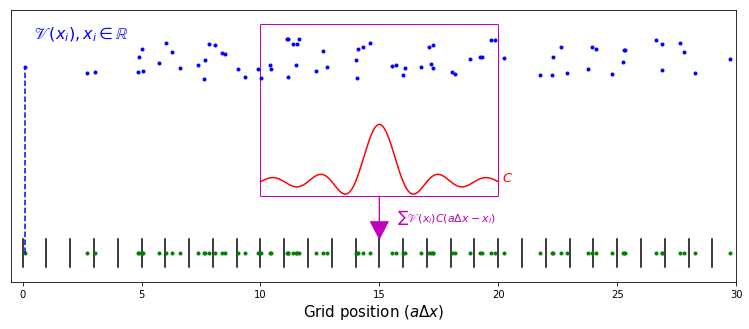

In [13]:
N = 30
dx = 1
a = np.arange(N)
M = 75
tap_pos = (N//2)*dx
conv_hsup = 5*dx
conv_x = np.linspace(-conv_hsup,conv_hsup,1000)
vis_x = np.sort(np.random.rand(M)*N*dx)
vis = 1.5+np.random.rand(M)*0.7 + 0.3
plt.figure(figsize=(13,5))
ax1 = plt.axes()
ax1.axes.get_yaxis().set_visible(False)
for x in a*dx:
    plt.plot([x,x],[-1.5,-1.0],'k')
plt.plot(vis_x,vis,'b.')
plt.plot(vis_x,np.ones([M])*-1.25,'g.')
plt.plot([vis_x[0],vis_x[0]],[-1.25,vis[0]],'b--')
plt.plot(tap_pos+conv_x,np.sinc(conv_x),'r')

plt.arrow(tap_pos-conv_hsup, -0.25, 0, 2.5+0.5, head_width=0.0, head_length=0.0, fc='m', ec='m')
plt.arrow(tap_pos+conv_hsup, -0.25, 0, 2.5+0.5, head_width=0.0, head_length=0.0, fc='m', ec='m')
plt.arrow(tap_pos-conv_hsup, -0.25, conv_hsup*2, 0, head_width=0.0, head_length=0.0, fc='m', ec='m')
plt.arrow(tap_pos-conv_hsup, 2.5+0.25, conv_hsup*2, 0, head_width=0.0, head_length=0.0, fc='m', ec='m')

plt.text(tap_pos+0.75, -0.70, "$\sum{\mathscr{V}(x_i)C(a\Delta{x}-x_i)}$", fontsize=11,color='m')
plt.text(tap_pos+conv_hsup+0.15, 0, "$C$", fontsize=13,color='r')
plt.text(0.5, 2.5, "$\mathscr{V}(x_i),x_i\in\mathbb{R}$", fontsize=16,color='b')
plt.arrow(tap_pos, -0.25, 0, -0.45, head_width=0.75, head_length=0.3, fc='m', ec='m')
plt.ylim(-1.75,3.0)
plt.xlim(-0.5*dx,N*dx)
plt.xlabel("Grid position ($a\Delta{x}$)",fontsize=15)
plt.show()



图：一维网格化处理过程。x轴上的绿色圆点表示可见度函数的采样位置，红色为卷积函数$C$，x轴上的短黑线表示规则间隔点，其值为可见度函数和卷积函数的卷积。

*Figure: Here we have illustrated the gridding process in one dimension. Given a continuous visibility function sampled at some, non-regular, points in $x$ and a convolution function, $C$, the points stored at regular intervals (black bars) is approximately a convolution between the visibility function and the convolution function. The coordinates the visibility function is sampled at, is plotted with green dots in-between the regularly sampled grid positions.*

权重函数$C$可以是线性、拉格朗日、辛格（多种窗口函数之一）、高斯、修改B样条在内的任意一种。

The weighting function, $C$ can be any number of functions proposed in the literature. These include linear, Lagrange, sinc (including one of the many window functions), Gaussian, modified B-spline, etc. 

您可能已经注意到了，上述插值函数非常接近离散卷积。如果重采样是在规则采样的数据上进行，卷积函数的步长间隔是规则的，则该函数可以视为普通的离散卷积函数。然而，严格意义上来说，这个函数并不是一个卷积函数。网格化和去网格化应该被认为是离散卷积的近似。即便如此，我们还是会在讨论中使用常规的卷积符号来表示。

You may have noticed that the interpolating function above is remarkably close to that of a discrete convolution. If the resampling was done on data that was regularly sampled and the convolution function evaluated at these regular discrete steps then the function would just the ordinary discrete convolution. However, the function as it stands is not quite a convolution by the strictest definition of the word. Gridding and degridding should be thought of as approximations to the discrete convolution. Nevertheless we will use the regular convolution notation in our discussion.

熟悉信号处理的可以把网格化和去网格化看成是上采样和下采样。跟传统的上采样一样，网格化时要先对采样点之间的空间进行零填充，唯一的不同点在于网格化时的原始测量值之间的间隔不规则，而上采样时的原始值之间的间隔是规则的。跟上采样一样，网格化时要对这些新填充的零值进行赋值，通过网格化，把值赋给支持范围内的网格点。

For those coming from a signal processing background it is useful to think of the convolutional gridding and degridding operations in terms of the ordinary upsampling and downsampling operations. In gridding, as with traditional upsampling, the space in-between samples are filled with zero values. The only difference is that with gridding the original measurements are not regularly-spaced, as would be the case with upsampling. Just as with upsampling it is then necessary to assign values to these new zero values in-between the measured values. With gridding the values are smeared out over the grid points within a some area of support.

值得注意的是，在网格化过程中，由于uv平面没有被全采样，因此很多网格点被置为0！事实上，有些网格点上的可见度并不为零，但是由于没有采样，所以只好给这些点分配一些值，置为0只是出于方便，并不代表真实的可见度值。在下一章[deconvolution &#10142;](6_Deconvolution/6_0_introduction.ipynb)我们还会讲到这一点，在此之前，需要我们掌握相关知识，能对这些点上的值做出相应的预测。

This is a very important point. During the gridding process, because the uv plane is not fully sampled, many of the grid points are assigned a value fo zero! Now, there is essantially no chance that a gridded visibility value is actually zero, but since we have not sampled that point in the visibility domain the only option is to assign that pixel some value. Zero is convenient, but not the true value. We will come back to this point in the next chapter on [deconvolution &#10142;](6_Deconvolution/6_0_introduction.ipynb) which requires us to include additional knowledge to make an informed guess about what the value of these pixels could be. 

基于上述知识，可以对网格化和去网格化给出更为严格的定义：

With this understanding in hand we can define gridding and degridding more rigorously:

\begin{equation}
 \begin{split}
     V_\text{gridded}[u,v]&=[(\mathscr{V}(u,v) \, S(u,v))\circ C(u,v)] \, III[u,v]\\
     V_\text{degridded}(u,v)&=[V_\text{gridded}[u,v]\circ C(u,v)] \, S(u,v)\\
 \end{split}
\end{equation}

网格化时先对采样的可见度做卷积（C为卷积函数），然后再通过shah函数（钉床函数）([$\S$ 2.2 &#10142;](../2_Mathematical_Groundwork/2_2_important_functions.ipynb))离散化到规则格点上。去网格化时则相反：对规则采样值做卷积，然后按照uv平面上的采样轨迹进行采样。在对可见度进行坐标变换之前，卷积函数在支持区域范围内对可见度进行“涂抹”（网格化）和“收集”（去网格化）。理想情况下，应该在网格化和去网格化过程中确定卷积函数，然而，由于网格化和去网格化处理的规模为$MC_\text{sup}^2$，考虑到计算成本，难以做到为每个可见度确定相应的卷积函数，所以通常采取一种较为简单的方式，预先给出一个一定大小的卷积函数。另外值得注意的是，采样间隔要比网格的格点间隔小很多；干涉仪在空间频率域进行测量，因此对采样的坐标进行任何较大的截断/舍入操作，都将导致图像的结构信息失去相关性。下图展示了从过采样滤波器中提取数值的过程。

In gridding the sampled visibilities are convolved with a convolution function then discretized onto regular points by the shah (bed-of-nails) function ([$\S$ 2.2 &#10142;](../2_Mathematical_Groundwork/2_2_important_functions.ipynb)). In degridding the opposite is done: the regularly sampled discerete values are convolved and sampled along the sampling tracks in the u,v plane. The convolution function smears (gridding) and gathers (degridding) the visibilities over / from some area of support before discretizing the visibilities to new coordinates. Ideally this function would be computed during the gridding and degridding operations, however, considering that the processing costs of gridding and degridding both scale as $MC_\text{sup}^2$ these functions can be too computationally expensive to compute for every visibility and is normally pretabulated for a given support size. Additionally it is important to sample this function much more densely than the spacings between grid cells; interferometers take measurements in the spatial frequency domain and any large snapping / rounding operation on the coordinates of the samples will result in a decorrelation in the structural information about the image. The figure below illustrates how values are picked from the oversampled filter.

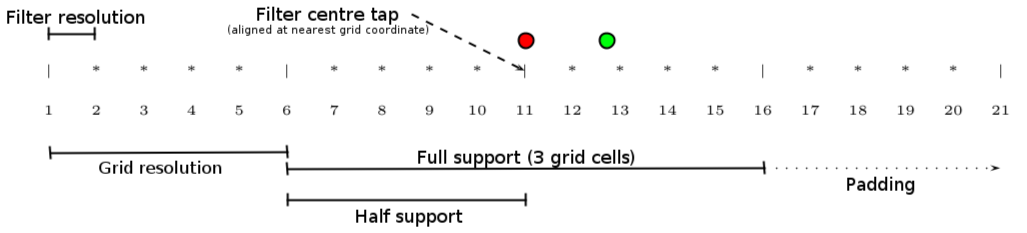

In [14]:
Image(filename="figures/oversampled_filter_illustration.png")

图：这是一个经过填充了的过采样滤波器，每个点都编了号，有一个3网格的全支持区域（中值两边的半支持的值为1）。该滤波器为5倍过采样，如图中星号所示。黑色短竖线表示了网格分辨率($\Delta{u}$ 或 $\Delta{v}$)。如果所测的uv坐标位置正好落在最近的网格上（如红点），则第6、11、16被选为插值系数；如果uv坐标稍稍偏离网格点(绿点)，则第8、13、18号被选为插值系数。这就像是把一张密一些的钉床架到了网格钉床上，好处在于在做卷积的时候，能够选用到更接近的插值系数。

*Figure: Here the indexing for a padded, oversampled filter is illustrated for a 3-cell full-support region (half support of 1 to both sides of the centre value), padded with one value on both sides. The filter is 5x oversampled, as indicated by the spaces between the asterisks. The bars represent the grid resolution ($\Delta{u}$ or $\Delta{v}$). If the measured uv coordinate falls exactly on the nearest grid cell (red dot) then values 6,11 and 16 are selected as interpolation coefficients. If the uv value is slightly offset, for instance $\text{round}(\text{fraction}(u, v)m_\text{oversample factor})$ = 2 (green dot), then 8, 13 and 18 are selected for the 3 interpolation coefficients. In other words: a denser bed of nails is placed over the bed of nails of the grid and the closest set of coefficients for the convolution are selected.*

更重要的是，卷积滤波器能减少混叠，这对FFT至关重要。基于卷积理论的射电天空重建图像可以表示为：

More importantly, the alias-reduction properties of the convolution filter being used are essential to the FFT approach. By the convolution theorem the reconstructed image of the radio sky can be stated as follows:

\begin{equation}
I_\text{dirty}[l,m] = ([I(l,m)\circ\text{PSF}(l,m)] \, c(l,m))\circ\mathscr{F}\{III\}[l,m]
\end{equation}

Shah函数的傅立叶变换$\mathscr{F}\{III\}[l,m]$在图像域是一系列的周期函数。对于包含$M\times N$个像素的图像，图像与这些周期函数的卷积会产生视场重复，重复周期为$M\Delta{\theta_l}$ 和$N\Delta{\theta_m}$，这正是需要消除的混叠效应，为此，我们希望卷积滤波器的傅立叶变换，即$c(l,m)$，能让下面的比值达到最大：

The Fourier transform of the shah function $\mathscr{F}\{III\}[l,m]$ is a series of periodic functions in the image domain. Convolution with these periodic functions replicates the field of view at a period of $M\Delta{\theta_l}$ and $N\Delta{\theta_m}$ for an $M\times N$ pixel image, and it is this aliasing effect that must be stopped. To that end one would hope that the Fourier transform of the convolution filter, $c(l,m)$, maximizes the following ratio:

\begin{equation}
\frac{\int_\text{FOV} \lvert c(l,m) \rvert^2dS}{\int_{-\infty}^\infty \lvert c(l,m) \rvert^2dS}
\end{equation}

简单来讲，就是希望函数$c$ 只在一个小的中央区域，即视场内，为非零。

Simply stated, it is desirable that the function $c$ is only non-zero over a small central region: the field of view.

在讲到滤波器的精度和抗混叠效应特点时，都不建议采用最近邻插值法。插值的精度对去网格化很重要，抗混叠效应对网格化很重要。最近邻插值（较早的文献中也称之为“cell-summing”）只是简单地把落在新坐标周边矩形框范围的点进行累计，而不考虑这些点跟新坐标点之间的距离。这种框函数的傅立叶变换是一个无限辛格函数，它波动着缓慢趋向无穷，混叠效应得不到很好地抑制。因此卷积网格/去网格选用了更好的卷积策略，在确定卷积权重时兼顾了格点和uv点之间的距离。

Both the remarks about accuracy and anti-aliasing properties of the filter precludes using a nearest-neighbour approach to interpolating points to and from regular coordinates. Interpolation accuracy takes presidence in degridding, while alias-reduction is important for gridding. Nearest-neighbour interpolation (also known as *cell-summing* in older literature) simply accumulates the neighbouring points that fall within a rectangular region around the new coordinate, without considering the distance those points are from the new coordinate. The Fourier transform of this box function is an infinite sinc function, which ripples out slowly towards infinity, and doesn't stop much of the aliasing effect. Convolutional gridding/degridding is therefore a more attractive approach, because the distance between the grid point and the measured uv point is taken into account when selecting a set of convolution weights.

用框函数的傅立叶变换（即一个无限辛格函数）可以抑制一部分混叠效应，但是计算代价太高，因此最好选择截断的辛格函数或者其它具有类似傅立叶变换特点的函数（这些函数的傅立叶变换后的能量主要集中在中央区域，而且下降很快）。下图展示了用截断辛格函数取代最近邻插值法所带来的显著效果。

The observation about the Fourier transform of the box function leads us to a partial solution for the aliasing problem, in that convolving with an *infinite* sinc will yield an image tapered by a box function. Unfortunately this is not computationally feasible and instead the best option is to convolve with either a truncated sinc function, or some other function that has a similar centre-heavy Fourier transform and preferably tapers off reasonably quickly. The images below illustrates the significant improvement using a truncated sinc function instead of nearest-neighbour interpolation.

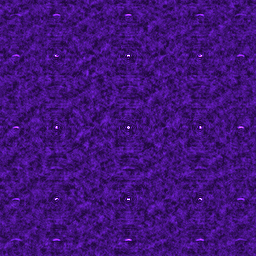

In [15]:
Image(filename="figures/NN_interpolation_aliasing.png", width=512)

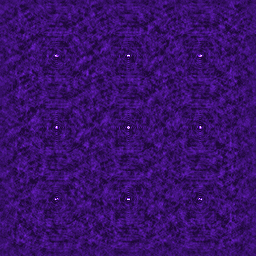

In [16]:
Image(filename="figures/AA_kernel_alias_reduction.png", width=512)

图：以上是两张多点源的综合成像。上图采用了网格累积（最近邻）插值，下图采用了带简单截断辛格函数的卷积重采样。上图，天空模型里落在视场外的源被混叠回了视场内；下图，混叠现象被截断辛格函数抑制。

*Figure: Above two synthesized images of a grid of point sources. The first using cell-summing (nearest neighbour) interpolation and the second using convolutional resampling with a simple truncated sinc function. In the first the sources of this grid sky pattern that fall slightly outside the field of view are aliased back into the field of view. In the second the aliasing energy is limited by the box response of the sinc function.*

下面是几种函数的傅立叶变换的旁瓣的幅度谱，可以看出，框函数的傅立叶变换的旁瓣要比截断辛格函数高出很多。

Below the magnitude of the sidelobes of the Fourier transforms of several functions are plotted. The sidelobes of the Fourier transform of the box function is significantly higher than that of truncated and windowed sinc functions.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


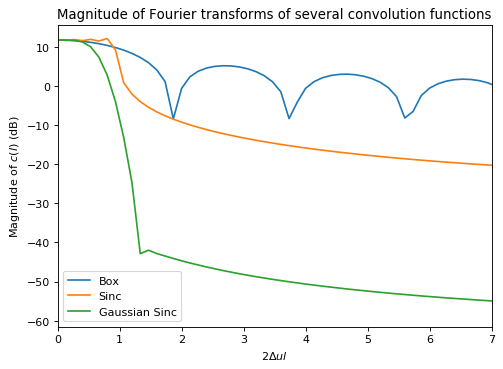

In [17]:
half_sup = 6
oversample = 15
full_sup_wo_padding = (half_sup * 2 + 1)
full_sup = full_sup_wo_padding + 2 #+ padding
no_taps = full_sup + (full_sup - 1) * (oversample - 1)
taps = np.arange(-no_taps//2,no_taps//2 + 1)/float(oversample)

#unit box
box = np.where((taps >= -0.5) & (taps <= 0.5),
               np.ones([len(taps)]),np.zeros([len(taps)]))
print(box)

fft_box = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(box))))
#truncated (boxed) sinc
sinc = np.sinc(taps)
fft_sinc = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinc))))
#gaussian sinc
alpha_1 = 1.55
alpha_2 = 2.52
gsinc = np.sin(np.pi/alpha_1*(taps+0.00000000001))/(np.pi*(taps+0.00000000001))*np.exp(-(taps/alpha_2)**2)
fft_gsinc = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(gsinc))))
#plot it up
plt.figure(figsize=(7, 5), dpi=80)
l = np.arange(-(no_taps)//2,(no_taps)//2+1) * (1.0/oversample)
a, = plt.plot(2*l, 10.*np.log10(fft_box))
b, = plt.plot(2*l, 10.*np.log10(fft_sinc))
c, = plt.plot(2*l, 10.*np.log10(fft_gsinc))
ax = plt.gca()
ax.set_xlim(0,no_taps//2 * (1.0/oversample))
#ax.set_yscale("log", nonposy='clip')
plt.legend([a,b,c],["Box","Sinc","Gaussian Sinc"])
plt.xlabel("$2\Delta{u}l$")
plt.ylabel("Magnitude of $c(l)$ (dB)")
plt.title("Magnitude of Fourier transforms of several convolution functions")
plt.show()

图：几种函数的傅立叶变换的功率谱。大部分能量集中在中央区域而且边缘急剧下降的，是比较理想的卷积函数。

*Figure: The magnitudes of the Fourier transforms of various functions. It is desirable that most of the energy of these functions fall within some central region and that the response drops off sharply at the edge of this central region*

通过卷积函数$c(l,m)$的傅立叶变换与图像逐点相除，可以抑制卷积函数对图像的影响。这起到了使带通效应变平缓的效果（移除了中央区域以外的锥形），但同时也增强了图像边缘处的混叠源的幅度。

After Fourier transformation the effects of the convolution function on the image can be mitigated by point-wise dividing the image through by the Fourier transform of the convolution function, $c(l,m)$. This has the effect of flattening the response of the passband, by removing the tapering towards the edges of the image, but raises the amplitude of any aliased sources at the edge of the image.

实际上，在诸如“lwimager”这样的图像处理程序中，有用到了椭球体函数，但这些函数超出了我们的讨论范围，读者可以自行参考Donald Rhodes的工作 [<cite data-cite='rhodes1970spheroidal'>On the Spheroidal Functions</cite> &#10548;](http://cdm16009.contentdm.oclc.org/cdm/compoundobject/collection/p13011coll6/id/61576/rec/50)，了解这些函数的详细定义及其对混叠效应的消除。

In practice the proloid spheroidal functions are used in imaging programs such as `lwimager`, but the definition of these functions are beyond the scope of the introductory discussion here and the reader is referred to the work of Donald Rhodes, [<cite data-cite='rhodes1970spheroidal'>On the Spheroidal Functions</cite> &#10548;](http://cdm16009.contentdm.oclc.org/cdm/compoundobject/collection/p13011coll6/id/61576/rec/50) for a detailed discussion of their definition and proof of their aliasing reduction properties.

同时也要注意到，在做网格化和去网格化时，不需要使用相同的卷积函数。在去网格化时，要重点关注的是对可见度预测的准确性。我们这里不强调直接傅立叶变换跟快速傅立叶变换的差异，大家可以参考来自Sze Tan的进一步讨论 [<cite data-cite='tan1986aperture'>Aperture-synthesis mapping and parameter estimation</cite> &#10548;](http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.ethos.384529)。

It is also worth noting that the convolution functions used in gridding and degridding need not be the same function. In degridding the focus is solidly on the accuracy of the predicted visibility. Here it can be advantageous to minimize the difference between a direct transformation approach and a Fast Fourier Transform approach with degridding, see for instance the discussion by Sze Tan, [<cite data-cite='tan1986aperture'>Aperture-synthesis mapping and parameter estimation</cite> &#10548;](http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.ethos.384529) for further detail. 

### 5.3.3 模拟器和成图器举例 Example Simulator and Imager

最后，我们给出几段代码，说明如何通过重采样和FFT进行预测和成图。首先，用我们之前见过的JVLA-D配置建立uv轨迹。回忆一下，图像分辨率由轨迹中最远的uv点确定，基线长度用波长度量。可以调整奈奎斯特采样率和图像大小，观察亚奈奎斯特采样率对图像角分辨率的影响。

We conclude this section with some sample code to illustrate prediction and imaging using resampling and the FFT. To start off let's set up a uv tracks as would be seen by the JVLA in D configuration. Recall that image resolution is given by the longest track in u and v and that the baseline is always measured in wavelengths. You can play around with the nyquist rate and image sizes. Notice how subnyquist sampling adversely affect the angular resolution of your image.

Maximum extent in uv: 3429.137814
Cell sizes in l,m: (46.269717,46.269717) arcsecs
Image size in pixels to cover 2.000 square degrees: (156,156)


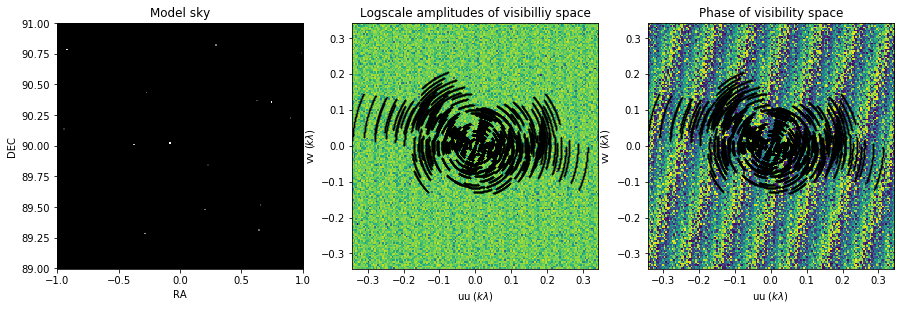

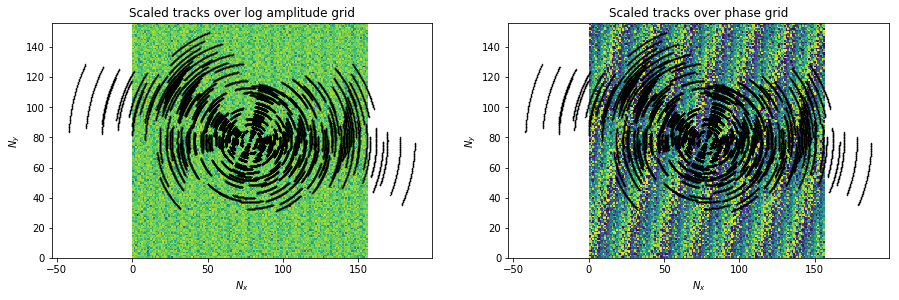

In [18]:
%run jvla_d_constants
RA = 0.0
DECLINATION = 90.0
global Nx, Ny, uvw, scaled_uv, model_sky, model_regular, max_uv, cell_size_l, cell_size_m
cellsize_slider=FloatSlider(min=0.25, #subnyquist
                            max=2.5,
                            value=1.0, 
                            step=0.1, 
                            continuous_update=False)
sampling_field = HBox([Label("Nyquist rate scaling factor (1x=critical sampling)"), cellsize_slider])
imsize_slider=FloatSlider(min=1,
                          max=3,
                          value=2.0,
                          step=0.1,
                          continuous_update=False)
imsize_field = HBox([Label("Image size scaling factor (1x=1deg)"), imsize_slider])

def interact_plot(key):
    global Nx, Ny, uvw, scaled_uv, model_sky, model_regular, max_uv, cell_size_l, cell_size_m
    #User defined scaling factors:
    clear_output(wait=True)
    sampling_tweek_factor = cellsize_slider.value #采样调节系数，默认为1，即奈奎斯特采样率
    im_size_tweek_factor = imsize_slider.value #图像大小调节系数
    
    #Set up interferometer sampling pattern
    uvw = track_simulator.sim_uv(RA, DECLINATION, 1.5, 60/3600.0, ENU, ARRAY_LATITUDE)

    #Work out the required sampling rate (let's just do a square grid for simplicity)
    max_uv = np.max(np.abs(uvw[:,0:2]/CENTRE_CHANNEL))
    print("Maximum extent in uv: %f" % (max_uv))
    cell_size_l = cell_size_m = np.rad2deg((1 / (2 * max_uv)) / sampling_tweek_factor) #分辨率
    print("Cell sizes in l,m: (%f,%f) arcsecs" % (cell_size_l*3600.0, cell_size_m*3600.0))

    #arbitrarily choose the field size to be 1.0 square degrees
    FIELD_SIZE = 1.0 * im_size_tweek_factor  

    #Then work out the number of pixels required to create a field of this size, given the nyquist image resolution
    Nx = int(np.round(FIELD_SIZE / cell_size_l))
    Ny = int(np.round(FIELD_SIZE / cell_size_m)) 
    print("Image size in pixels to cover %.3f square degrees: (%d,%d)" % (FIELD_SIZE, Nx, Ny))

    #Setup a random model sky consisting of point sources:
    model_sky = np.zeros([Nx,Ny])
    for i in range(15):
        model_sky[int(np.random.rand()*Nx),int(np.random.rand()*Ny)] = np.random.rand()*5.0 
    model_regular = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(model_sky)))

    #In the DFT we can pick the sampling rate in l and m directly when we evaluate a sum for each pixel.
    #However when using the FFT we have to employ the similarity theorem: a multiplication in one domain
    #results in a division in the other domain. Thus we scale the invertion such that it ranges from 
    #-0.5*N*cell_size <= pixel <= 0.5*N*cell_size
    scaled_uv = np.copy(uvw[:,0:2])
    scaled_uv[:,0] *= np.deg2rad(cell_size_l * Nx)
    scaled_uv[:,1] *= np.deg2rad(cell_size_m * Ny)
    
    #Finally plot up the results
    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.title("Model sky")
    plt.ticklabel_format(useOffset=False)
    plt.imshow(model_sky,cmap="gray", extent=[RA - Nx / 2 * cell_size_l, RA + Nx / 2 * cell_size_l,
                                              DECLINATION - Ny / 2 * cell_size_m, DECLINATION + Ny / 2 * cell_size_m])
    plt.xlabel("RA")
    plt.ylabel("DEC")
    plt.subplot(132)
    plt.title("Logscale amplitudes of visibilliy space")
    plt.imshow(10*np.log10(np.abs(model_regular+0.000000000001)), extent=[-max_uv/1e4, +max_uv/1e4,
                                                                          -max_uv/1e4, +max_uv/1e4])
    plt.plot(uvw[:,0]/CENTRE_CHANNEL/1e4,
             uvw[:,1]/CENTRE_CHANNEL/1e4,
             "k.",label="Baselines", markersize=1)

    plt.xlabel("uu $(k\lambda)$")
    plt.ylabel("vv $(k\lambda)$")
    plt.subplot(133)
    plt.title("Phase of visibility space")
    plt.imshow(np.angle(model_regular), extent=[-max_uv/1e4, +max_uv/1e4,
                                                -max_uv/1e4, +max_uv/1e4])
    plt.plot(uvw[:,0]/CENTRE_CHANNEL/1e4,
             uvw[:,1]/CENTRE_CHANNEL/1e4,
             "k.",label="Baselines", markersize=1)
    plt.xlabel("uu $(k\lambda)$")
    plt.ylabel("vv $(k\lambda)$")
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title("Scaled tracks over log amplitude grid")
    plt.imshow(10*np.log10(np.abs(model_regular+0.000000000001)), extent = [0,Nx,0,Ny])
    plt.plot(scaled_uv[:,0]/CENTRE_CHANNEL + Nx / 2,
             scaled_uv[:,1]/CENTRE_CHANNEL + Ny / 2,
             "k.",label="Baselines", markersize=1)
    plt.xlabel("$N_x$")
    plt.ylabel("$N_y$")
    plt.subplot(122)
    plt.title("Scaled tracks over phase grid")
    plt.imshow(np.angle(model_regular), extent = [0,Nx,0,Ny])
    plt.plot(scaled_uv[:,0]/CENTRE_CHANNEL + Nx / 2,
             scaled_uv[:,1]/CENTRE_CHANNEL + Ny / 2,
             "k.",label="Baselines", markersize=1)
    plt.xlabel("$N_x$")
    plt.ylabel("$N_y$")
    plt.show()

interact_plot("")
cellsize_slider.observe(interact_plot)
display(sampling_field)
imsize_slider.observe(interact_plot)
display(imsize_field)


图：模拟天空模型（l,m空间）和相应的傅立叶变换可见度空间（u，v空间）。叠加在uv空间上的黑色线条是JVLA-D的uv轨迹。可以看出，当采样率低于奈奎斯特采样率（即采样系数小于1）时，将会损失角分辨率，因为较长的基线落到了网格以外，不能参与成图。

*Figure: The simulated model sky (l,m space) and its fourier transform in the visibility space (u,v space). Overlayed on top are the uv tracks for JVLA D. In the bottom plots the scaled tracks are overlayed on the grid predicted from the model. As you can see if subnyquist rates are chosen angular resolution is lost because the long baselines fall outside the grid and must be discarded during imaging*

为了完成预测（也被称为前向“forward”步骤），要用到上面讨论过的去网格化算法按照干涉仪的uv轨迹对测量值进行重采样。为了“预测”出某个uv坐标上的测量值，需要沿着采样轨迹，收集每个临近点的测量值并赋予相应的权重。

To complete the prediction (also known as the "forward" step) the measurements are resampled onto the u,v tracks of the interferometer using the *degridding* algorithm discussed above. Measurements are gathered and weighted from the vacinity of each of the points along the sampling track in order to "predict" a value at the u,v coordinate.

In [19]:
# %load convolutional_degridder.py
import numpy as np

def fft_degrid(model_image, uvw, ref_lda, Nx, Ny, convolution_filter):
    """
    Convolutional gridder (continuum)

    Keyword arguments:
    model_image --- Model image
    uvw --- interferometer's scaled uvw coordinates
            (Prerequisite: these uv points are already scaled by the similarity
            theorem, such that -N_x*Cell_l*0.5 <= theta_l <= N_x*Cell_l*0.5 and
            -N_y*Cell_m*0.5 <= theta_m <= N_y*Cell_m*0.5)
    ref_lda --- array of reference lambdas (size of vis channels)
    Nx,Ny --- size of image in pixels
    convolution_filter --- pre-instantiated AA_filter anti-aliasing
                           filter object
    """
    assert model_image.ndim == 3
    filter_index = \
        np.arange(-convolution_filter.half_sup,convolution_filter.half_sup+1)
    model_vis_regular = np.zeros(model_image.shape, dtype=np.complex64)
    for p in range(model_image.shape[0]):
        model_vis_regular[p, :, :] = \
            np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(model_image[p, :, :])))
    vis = \
        np.zeros([uvw.shape[0],
                  ref_lda.shape[0],
                  model_image.shape[0]],
                 dtype=np.complex)

    for r in range(uvw.shape[0]):
        for c in range(vis.shape[1]):
            scaled_uv = uvw[r,:] / ref_lda[c]
            disc_u = int(np.round(scaled_uv[0]))
            disc_v = int(np.round(scaled_uv[1]))
            frac_u_offset = int((1 + convolution_filter.half_sup +
                                 (-scaled_uv[0] + disc_u)) *
                                convolution_filter.oversample)
            frac_v_offset = int((1 + convolution_filter.half_sup +
                                 (-scaled_uv[1] + disc_v)) *
                                convolution_filter.oversample)

            if (disc_v + Ny // 2 + convolution_filter.half_sup >= Ny or
                disc_u + Nx // 2 + convolution_filter.half_sup >= Nx or
                disc_v + Ny // 2 - convolution_filter.half_sup < 0 or
                disc_u + Nx // 2 - convolution_filter.half_sup < 0):
                continue
            for conv_v in filter_index:
                v_tap = \
                    convolution_filter.filter_taps[conv_v *
                                                   convolution_filter.oversample
                                                   + frac_v_offset]
                grid_pos_v = disc_v + conv_v + Ny // 2
                for conv_u in filter_index:
                    u_tap = \
                        convolution_filter.filter_taps[conv_u *
                                                       convolution_filter.oversample
                                                       + frac_u_offset]
                    conv_weight = v_tap * u_tap
                    grid_pos_u = disc_u + conv_u + Nx // 2
                    for p in range(vis.shape[2]):
                        vis[r, c, p] += \
                            model_vis_regular[p,
                                              grid_pos_v,
                                              grid_pos_u] * conv_weight

    return vis


In [20]:
tabulated_filter = AA_filter.AA_filter(3,63,"sinc")
vis = fft_degrid(model_sky.reshape(1, Ny, Nx), scaled_uv, np.array([CENTRE_CHANNEL]), Nx, Ny, tabulated_filter)

接下来是一个简单的通过FFT和网格化实现的成图处理过程。通过加权处理，不规则uv轨迹上的每个可见度值被重采样到了规则的坐标点上，经过逆FFT变换，从频域变到空域，从而得到近似的天空模型。

Next comes a simplified imaging step using the FFT and gridding. The visibilities on the irregularly-spaced u,v tracks are resampled onto regular coordinates. This is done by weighting and smearing each measured visibility out onto the regular coordinates in the vacinity of its u,v coordinate. After resampling the inverse FFT is used to transform the measurements in the spatial frequency domain to those in the spacial domain, thereby approximately reconstructing the model sky we started with.

In [27]:
# %load convolutional_gridder.py
import numpy as np

def grid_ifft(vis, uvw, ref_lda, Nx, Ny, convolution_filter):
    """
    Convolutional gridder (continuum)

    Keyword arguments:
    vis --- Visibilities as sampled by the interferometer
    uvw --- interferometer's scaled uvw coordinates
            (Prerequisite: these uv points are already scaled by the similarity
            theorem, such that -N_x*Cell_l*0.5 <= theta_l <= N_x*Cell_l*0.5 and
            -N_y*Cell_m*0.5 <= theta_m <= N_y*Cell_m*0.5)
    ref_lda --- array of reference lambdas (size of vis channels)
    Nx,Ny --- size of image in pixels
    convolution_filter --- pre-instantiated AA_filter anti-aliasing
                           filter object
    """
    assert vis.shape[1] == ref_lda.shape[0], (vis.shape[1], ref_lda.shape[0])
    filter_index = \
        np.arange(-convolution_filter.half_sup,convolution_filter.half_sup+1)
    # one grid for the resampled visibilities per correlation:
    measurement_regular = \
        np.zeros([vis.shape[2],Ny,Nx],dtype=np.complex)
    # for deconvolution the PSF should be 2x size of the image (see 
    # Hogbom CLEAN for details), one grid for the sampling function:
    sampling_regular = \
        np.zeros([2*Ny,2*Nx],dtype=np.complex)
    for r in range(uvw.shape[0]):
        for c in range(vis.shape[1]):
            scaled_uv = uvw[r,:] / ref_lda[c]
            disc_u = int(np.round(scaled_uv[0]))
            disc_v = int(np.round(scaled_uv[1]))
            frac_u_offset = int((1 + convolution_filter.half_sup +
                                 (-scaled_uv[0] + disc_u)) *
                                convolution_filter.oversample)
            frac_v_offset = int((1 + convolution_filter.half_sup +
                                 (-scaled_uv[1] + disc_v)) *
                                convolution_filter.oversample)
            disc_u_psf = int(np.round(scaled_uv[0]*2))
            disc_v_psf = int(np.round(scaled_uv[1]*2))
            frac_u_offset_psf = int((1 + convolution_filter.half_sup +
                                     (-scaled_uv[0]*2 + disc_u_psf)) *
                                    convolution_filter.oversample)
            frac_v_offset_psf = int((1 + convolution_filter.half_sup +
                                     (-scaled_uv[1]*2 + disc_v_psf)) *
                                    convolution_filter.oversample)
            if (disc_v + Ny // 2 + convolution_filter.half_sup >= Ny or
                disc_u + Nx // 2 + convolution_filter.half_sup >= Nx or
                disc_v + Ny // 2 - convolution_filter.half_sup < 0 or
                disc_u + Nx // 2 - convolution_filter.half_sup < 0):
                continue
            for conv_v in filter_index:
                v_tap = \
                    convolution_filter.filter_taps[conv_v *
                                                   convolution_filter.oversample
                                                   + frac_v_offset]
                v_tap_psf = \
                    convolution_filter.filter_taps[conv_v *
                                                   convolution_filter.oversample
                                                   + frac_v_offset_psf]

                grid_pos_v = disc_v + conv_v + Ny // 2
                grid_pos_v_psf = disc_v_psf + conv_v + Ny
                for conv_u in filter_index:
                    u_tap = \
                        convolution_filter.filter_taps[conv_u *
                                                       convolution_filter.oversample
                                                       + frac_u_offset]
                    u_tap_psf = \
                        convolution_filter.filter_taps[conv_u *
                                                       convolution_filter.oversample
                                                       + frac_u_offset_psf]
                    conv_weight = v_tap * u_tap
                    conv_weight_psf = v_tap_psf * u_tap_psf
                    grid_pos_u = disc_u + conv_u + Nx // 2
                    grid_pos_u_psf = disc_u_psf + conv_u + Nx
                    for p in range(vis.shape[2]):
                        measurement_regular[p, grid_pos_v, grid_pos_u] += \
                            vis[r, c, p] * conv_weight
                    # assuming the PSF is the same for different correlations:
                    sampling_regular[grid_pos_v_psf, grid_pos_u_psf] += \
                        (1+0.0j) * conv_weight_psf

    dirty = np.zeros(measurement_regular.shape, dtype=measurement_regular.dtype)
    psf = np.zeros(sampling_regular.shape, dtype=sampling_regular.dtype)

  
    for p in range(vis.shape[2]):
        dirty[p,:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(measurement_regular[p,:,:])))
    psf[:,:] = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sampling_regular[:,:])))
    return dirty,psf


In [28]:
tabulated_filter = AA_filter.AA_filter(3,63,"sinc")
dirty_sky, psf = grid_ifft(vis, scaled_uv, np.array([CENTRE_CHANNEL]), Nx, Ny, tabulated_filter)

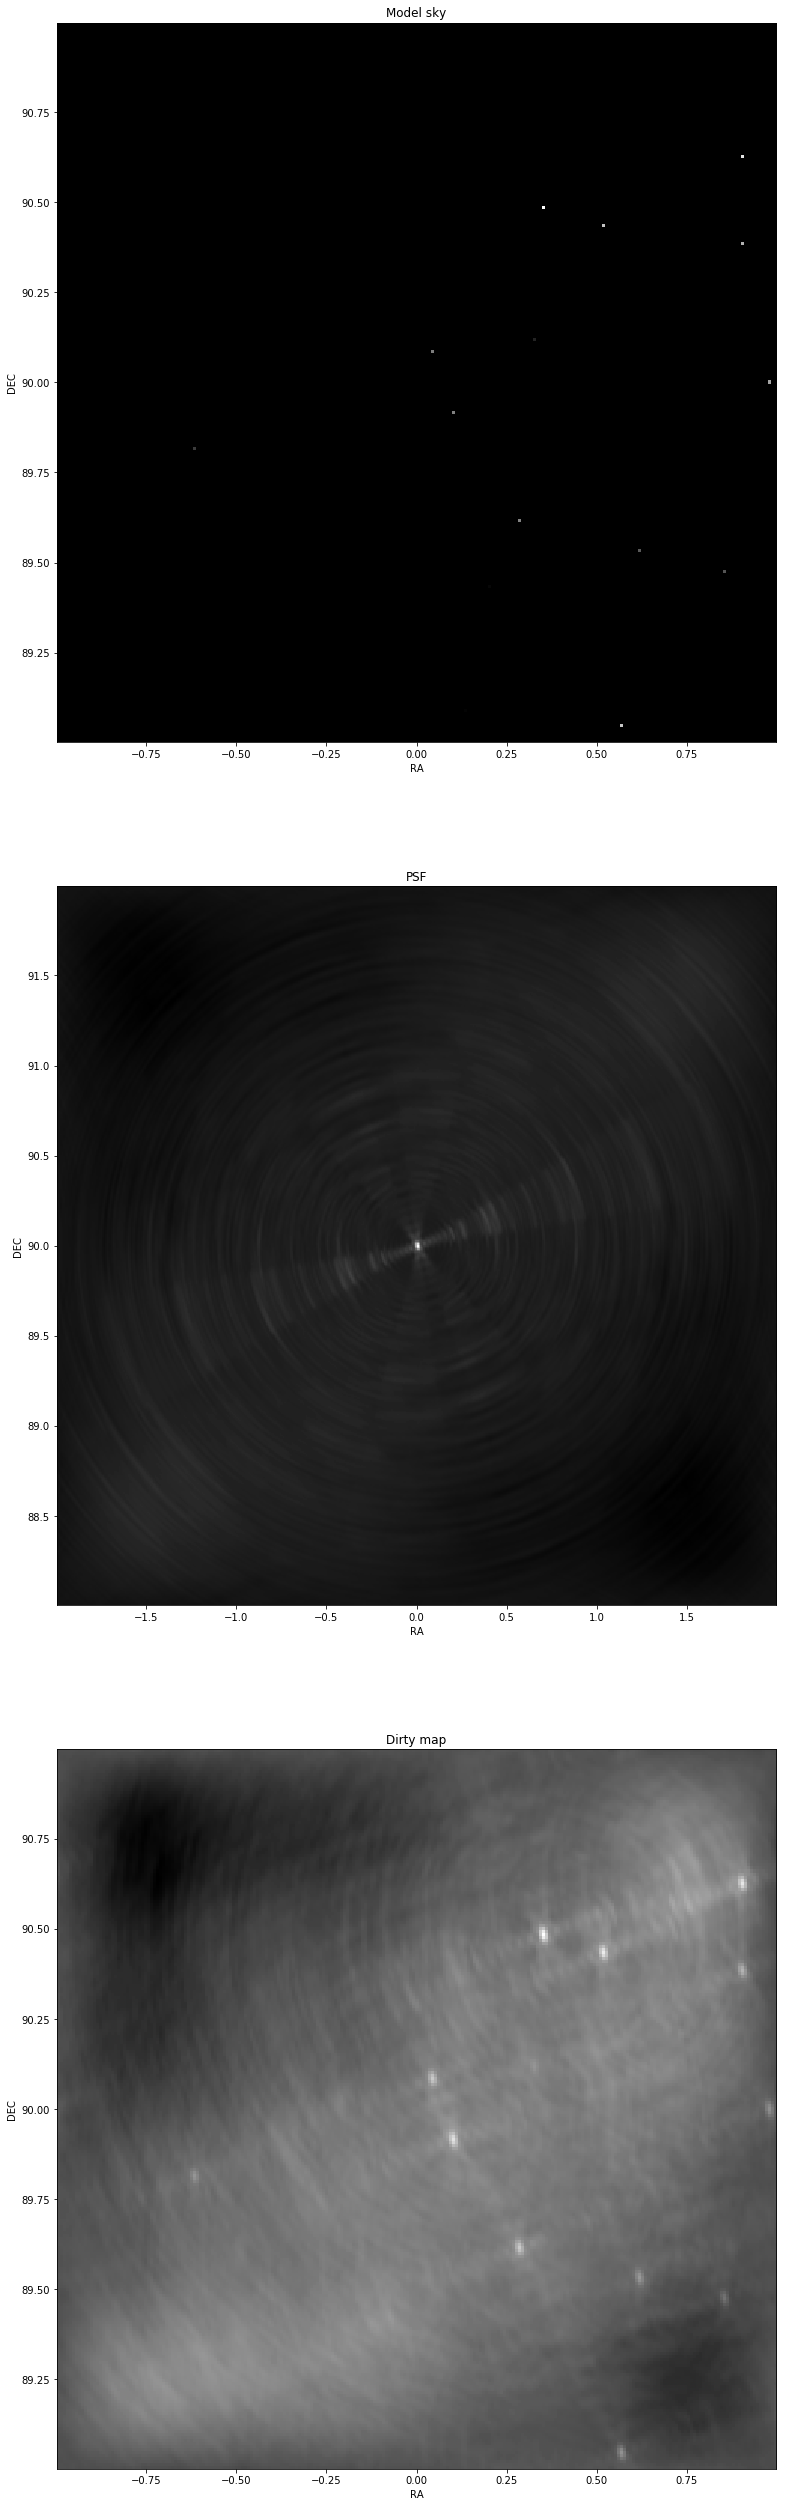

In [23]:
#plot it up :-)
plt.figure(figsize=(15, 45))
plt.subplot(311)
plt.title("Model sky")
plt.imshow(model_sky,cmap="gray", extent=[RA - Nx / 2 * cell_size_l, RA + Nx / 2 * cell_size_l,
                                          DECLINATION - Ny / 2 * cell_size_m, DECLINATION + Ny / 2 * cell_size_m])
plt.xlabel("RA")
plt.ylabel("DEC")
plt.subplot(312)
plt.title("PSF")
plt.imshow(np.real(psf[:, :]),cmap="gray", extent=[RA - Nx * 2 / 2 * cell_size_l, RA + Nx * 2 / 2 * cell_size_l,
                                                   DECLINATION - Ny * 2 / 2 * cell_size_m, DECLINATION + Ny * 2 / 2 * cell_size_m])
plt.xlabel("RA")
plt.ylabel("DEC")
plt.subplot(313)
plt.title("Dirty map")
plt.imshow(np.real(dirty_sky[0, :, :]),cmap="gray", extent=[RA - Nx / 2 * cell_size_l, RA + Nx / 2 * cell_size_l,
                                                            DECLINATION - Ny / 2 * cell_size_m, DECLINATION + Ny / 2 * cell_size_m])
plt.xlabel("RA")
plt.ylabel("DEC")
plt.show()

图：天空模型的重建图。卷积引入的旁瓣导致脏图上的暗弱源几乎不可见。

*Figure: Reconstructed image of the model sky. This "dirty" image is convolved with the the PSF shown in the centre figure. Some of the fainter sources are hardly visible because of the sidelobes introduced by this convolution.*

当然，重建只是天空模型的一个近似，因为我们只对uv平面进行了部分采样。因为观测时间够长，所以最亮的源还是清晰可见。重建图上亮源周边的PSF的环状结构清晰可见，而暗弱源则变得非常模糊。后面讲到的去卷积策略将从重建图中去除这些psf结构，从而提高图像的保真度。

Of course this reconstruction can only ever be approximate, since the u,v plane is only partially sampled. The brightest sources are still visible, provided the observation time is long enough. Each of the sources are convolved with the PSF shown above in the centre figure; the ring-like structure of the PSF is clearly visible around the bright sources and can, in the worst case, obscure some of the fainter sources in the image. The deconvolution strategies discussed later attempt to remove the psf structure from the images and improve the fidelity of the reconstructed images.

***

* Next: [5.4 The Dirty Image and Visibility Weights](5_4_imaging_weights.ipynb)